In [1]:
import pandas as pd
from os import path
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Conv1D, GlobalMaxPooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import TextVectorization
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score
from math import pi
from tensorflow.keras.layers import GRU
import numpy as np
import seaborn as sns
import os

# Định nghĩa đường dẫn
DATA_DIR = r"c:\Users\Admin\Python\ABSA_Prompting\data"
RESULT_DIR = r"c:\Users\Admin\Python\ABSA_Prompting\results"
os.makedirs(DATA_DIR, exist_ok=True)
os.makedirs(RESULT_DIR, exist_ok=True)

In [2]:
# CONFIG - Restaurant Dataset
ViABSA_dir = path.join(DATA_DIR, 'ViABSA_Restaurant')

train_file = path.join(ViABSA_dir, 'data_train.csv')
test_file = path.join(ViABSA_dir, 'data_test.csv')

train_df = pd.read_csv(train_file)
test_df = pd.read_csv(test_file)

print("Restaurant train dataset shape:", train_df.shape)
print("Restaurant test dataset shape:", test_df.shape)
print("Columns:", train_df.columns.tolist())
print("\nTrain data sample:")
train_df.head()

Restaurant train dataset shape: (2961, 13)
Restaurant test dataset shape: (500, 13)
Columns: ['Review', 'AMBIENCE#GENERAL', 'DRINKS#PRICES', 'DRINKS#QUALITY', 'DRINKS#STYLE&OPTIONS', 'FOOD#PRICES', 'FOOD#QUALITY', 'FOOD#STYLE&OPTIONS', 'LOCATION#GENERAL', 'RESTAURANT#GENERAL', 'RESTAURANT#MISCELLANEOUS', 'RESTAURANT#PRICES', 'SERVICE#GENERAL']

Train data sample:


,Review,AMBIENCE#GENERAL,DRINKS#PRICES,DRINKS#QUALITY,DRINKS#STYLE&OPTIONS,FOOD#PRICES,FOOD#QUALITY,FOOD#STYLE&OPTIONS,LOCATION#GENERAL,RESTAURANT#GENERAL,RESTAURANT#MISCELLANEOUS,RESTAURANT#PRICES,SERVICE#GENERAL
0,"_ Ảnh chụp từ hôm qua, đi chơi với gia đình và...",0,0,0,0,0,3,3,0,0,0,0,0
1,"_Hương vị thơm ngon, ăn cay cay rất thích, nêm...",1,0,0,0,3,1,1,0,1,0,3,2
2,- 1 bàn tiệc hoành tráng 3 đứa ăn no muốn tắt ...,2,0,0,0,1,1,1,2,1,1,0,1
3,- Các bạn nhìn cái chảo này có to không 🙄🙄🙄- T...,0,0,0,0,0,1,1,0,1,0,0,0
4,"- Cháo: có nhiều hương cho các bạn chọn, nhưng...",0,0,0,0,0,1,1,0,0,0,0,0


In [3]:
# PREPROCESSING - Restaurant Dataset
# Using separate train and test files (no need to split)

aspect_columns = [col for col in train_df.columns if col != 'Review']
print(f"Found {len(aspect_columns)} aspects:", aspect_columns)

print(f"Train set: {train_df.shape}")
print(f"Test set: {test_df.shape}")

# Display sample
print("\nTest data sample:")
test_df.head()

Found 12 aspects: ['AMBIENCE#GENERAL', 'DRINKS#PRICES', 'DRINKS#QUALITY', 'DRINKS#STYLE&OPTIONS', 'FOOD#PRICES', 'FOOD#QUALITY', 'FOOD#STYLE&OPTIONS', 'LOCATION#GENERAL', 'RESTAURANT#GENERAL', 'RESTAURANT#MISCELLANEOUS', 'RESTAURANT#PRICES', 'SERVICE#GENERAL']
Train set: (2961, 13)
Test set: (500, 13)

Test data sample:


,Review,AMBIENCE#GENERAL,DRINKS#PRICES,DRINKS#QUALITY,DRINKS#STYLE&OPTIONS,FOOD#PRICES,FOOD#QUALITY,FOOD#STYLE&OPTIONS,LOCATION#GENERAL,RESTAURANT#GENERAL,RESTAURANT#MISCELLANEOUS,RESTAURANT#PRICES,SERVICE#GENERAL
0,Đây là 1 trong những quán mà mình thích vì vị ...,0,3,1,3,0,0,0,0,1,0,0,0
1,Bữa lướt facebook nhỏ bạn thấy có check-in ly ...,0,0,1,1,1,1,1,3,0,3,0,0
2,Nghe phông phanh về trà sữa có viên phô mai to...,1,1,1,1,0,0,1,0,1,0,0,0
3,"Lại là mình tín đồ nghiện trà sữa đây, thấy qu...",1,0,1,3,0,1,1,1,0,0,1,1
4,Không gian quán sang trọng khá đẹp mang phong ...,1,0,0,0,0,1,1,0,0,0,1,1


In [4]:
# SET-UP DATA for BiLSTM
# Restaurant dataset uses numerical sentiment: 0=none, 1=positive, 2=neutral, 3=negative

# Create binary labels for aspect detection (!=0 means aspect is present)
for aspect in aspect_columns:
    train_df[aspect + "_label"] = (train_df[aspect] != 0).astype(int)
    test_df[aspect + "_label"] = (test_df[aspect] != 0).astype(int)

aspect_labels = [aspect + "_label" for aspect in aspect_columns]

# Prepare data for BiLSTM
X_train = train_df['Review']
y_train_aspect = train_df[aspect_labels]
X_test = test_df['Review']
y_test_aspect = test_df[aspect_labels]

print("X_train shape:", X_train.shape)
print("y_train_aspect shape:", y_train_aspect.shape)
print("X_test shape:", X_test.shape) 
print("y_test_aspect shape:", y_test_aspect.shape)

# Check aspect distribution
print("\nAspect distribution in training set:")
for aspect in aspect_columns:
    count = (train_df[aspect] != 0).sum()
    print(f"{aspect}: {count} samples ({count/len(train_df)*100:.1f}%)")

y_train_aspect.head()

X_train shape: (2961,)
y_train_aspect shape: (2961, 12)
X_test shape: (500,)
y_test_aspect shape: (500, 12)

Aspect distribution in training set:
AMBIENCE#GENERAL: 737 samples (24.9%)
DRINKS#PRICES: 102 samples (3.4%)
DRINKS#QUALITY: 114 samples (3.9%)
DRINKS#STYLE&OPTIONS: 102 samples (3.4%)
FOOD#PRICES: 1401 samples (47.3%)
FOOD#QUALITY: 2658 samples (89.8%)
FOOD#STYLE&OPTIONS: 1746 samples (59.0%)
LOCATION#GENERAL: 373 samples (12.6%)
RESTAURANT#GENERAL: 855 samples (28.9%)
RESTAURANT#MISCELLANEOUS: 151 samples (5.1%)
RESTAURANT#PRICES: 263 samples (8.9%)
SERVICE#GENERAL: 795 samples (26.8%)


,AMBIENCE#GENERAL_label,DRINKS#PRICES_label,DRINKS#QUALITY_label,DRINKS#STYLE&OPTIONS_label,FOOD#PRICES_label,FOOD#QUALITY_label,FOOD#STYLE&OPTIONS_label,LOCATION#GENERAL_label,RESTAURANT#GENERAL_label,RESTAURANT#MISCELLANEOUS_label,RESTAURANT#PRICES_label,SERVICE#GENERAL_label
0,0,0,0,0,0,1,1,0,0,0,0,0
1,1,0,0,0,1,1,1,0,1,0,1,1
2,1,0,0,0,1,1,1,1,1,1,0,1
3,0,0,0,0,0,1,1,0,1,0,0,0
4,0,0,0,0,0,1,1,0,0,0,0,0


# **BiLSTM for Restaurant Aspect Detection**

In [5]:
# Text Vectorization
print("Setting up text vectorization...")
print("X_train dtype:", X_train.dtype)
print("y_train_aspect dtypes:", y_train_aspect.dtypes.unique())

vectorizer = TextVectorization()
vectorizer.adapt(X_train.astype(str))

X_train_BiLSTM = vectorizer(X_train.astype(str))
X_test_BiLSTM = vectorizer(X_test.astype(str))

print("X_train_BiLSTM shape:", X_train_BiLSTM.shape)
print("X_test_BiLSTM shape:", X_test_BiLSTM.shape)

Setting up text vectorization...
X_train dtype: object
y_train_aspect dtypes: [dtype('int64')]
X_train_BiLSTM shape: (2961, 612)
X_test_BiLSTM shape: (500, 415)
X_train_BiLSTM shape: (2961, 612)
X_test_BiLSTM shape: (500, 415)


In [6]:
'''
BiLSTM Model for Multi-label Aspect Detection
- Multi-label: Each sample can have multiple aspects simultaneously 
- Use sigmoid activation (not softmax) for independent probability per aspect
- Use binary_crossentropy loss for multi-label classification
'''

vocab_size = len(vectorizer.get_vocabulary())
print(f"Vocabulary size: {vocab_size}")
print(f"Number of aspects: {len(aspect_labels)}")

# Build BiLSTM model
BiLSTM = Sequential([
    Embedding(input_dim=vocab_size, output_dim=100), 
    Bidirectional(LSTM(64)),
    Dense(len(aspect_labels), activation='sigmoid')  # sigmoid for multi-label
])

print("Model architecture:")
BiLSTM.summary()

# Compile model
BiLSTM.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Train model
print("\nTraining BiLSTM model...")
history = BiLSTM.fit(X_train_BiLSTM, y_train_aspect, epochs=5, batch_size=32, validation_split=0.2)

# Make predictions
print("\nMaking predictions...")
y_pred_aspect = BiLSTM.predict(X_test_BiLSTM)

Vocabulary size: 8841
Number of aspects: 12
Model architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)


Training BiLSTM model...
Epoch 1/5
74/74 ━━━━━━━━━━━━━━━━━━━━ 14s 165ms/step - accuracy: 0.3390 - loss: 0.5024 - val_accuracy: 0.3255 - val_loss: 0.4039
Epoch 2/5
74/74 ━━━━━━━━━━━━━━━━━━━━ 14s 165ms/step - accuracy: 0.3390 - loss: 0.5024 - val_accuracy: 0.3255 - val_loss: 0.4039
Epoch 2/5
74/74 ━━━━━━━━━━━━━━━━━━━━ 11s 143ms/step - accuracy: 0.3529 - loss: 0.3610 - val_accuracy: 0.3255 - val_loss: 0.3822
Epoch 3/5
74/74 ━━━━━━━━━━━━━━━━━━━━ 11s 143ms/step - accuracy: 0.3529 - loss: 0.3610 - val_accuracy: 0.3255 - val_loss: 0.3822
Epoch 3/5
74/74 ━━━━━━━━━━━━━━━━━━━━ 10s 136ms/step - accuracy: 0.3519 - loss: 0.3368 - val_accuracy: 0.3255 - val_loss: 0.3668
Epoch 4/5
74/74 ━━━━━━━━━━━━━━━━━━━━ 10s 136ms/step - accuracy: 0.3519 - loss: 0.3368 - val_accuracy: 0.3255 - val_loss: 0.3668
Epoch 4/5
74/74 ━━━━━━━━━━━━━━━━━━━━ 11s 143ms/step - accuracy: 0.3377 - loss: 0.3175 - val_accuracy: 0.3052 - val_loss: 0.3597
Epoch 5/5
74/74 ━━━━━━━━━━━━━━━━━━━━ 11s 143ms/step - accuracy: 0.3377 - loss:

In [ ]:
y_pred_aspect_binary = (y_pred_aspect >= 0.5).astype(int)

f1_ad = f1_score(y_test_aspect, y_pred_aspect_binary, average='micro')
print(f"\nF1_ad (Aspect Detection): {f1_ad:.4f}")

print("\nPer-aspect F1 scores:")
for i, aspect in enumerate(aspect_columns):
    if aspect + "_label" in y_test_aspect.columns:
        f1 = f1_score(y_test_aspect[aspect + "_label"], y_pred_aspect_binary[:, i])
        print(f"{aspect}: {f1:.4f}")

print(f"\nOverall Statistics:")
print(f"Total predictions: {len(y_pred_aspect_binary)}")
print(f"True positives (any aspect): {(y_test_aspect.sum(axis=1) > 0).sum()}")
print(f"Predicted positives (any aspect): {(y_pred_aspect_binary.sum(axis=1) > 0).sum()}")


F1_ad (Aspect Detection): 0.6645

Per-aspect F1 scores:
AMBIENCE#GENERAL: 0.7098
DRINKS#PRICES: 0.0000
DRINKS#QUALITY: 0.0000
DRINKS#STYLE&OPTIONS: 0.0000
FOOD#PRICES: 0.7493
FOOD#QUALITY: 0.9551
FOOD#STYLE&OPTIONS: 0.8392
LOCATION#GENERAL: 0.1854
RESTAURANT#GENERAL: 0.4314
RESTAURANT#MISCELLANEOUS: 0.0000
RESTAURANT#PRICES: 0.0000
SERVICE#GENERAL: 0.5581

Overall Statistics:
Total predictions: 500
True positives (any aspect): 500
Predicted positives (any aspect): 500


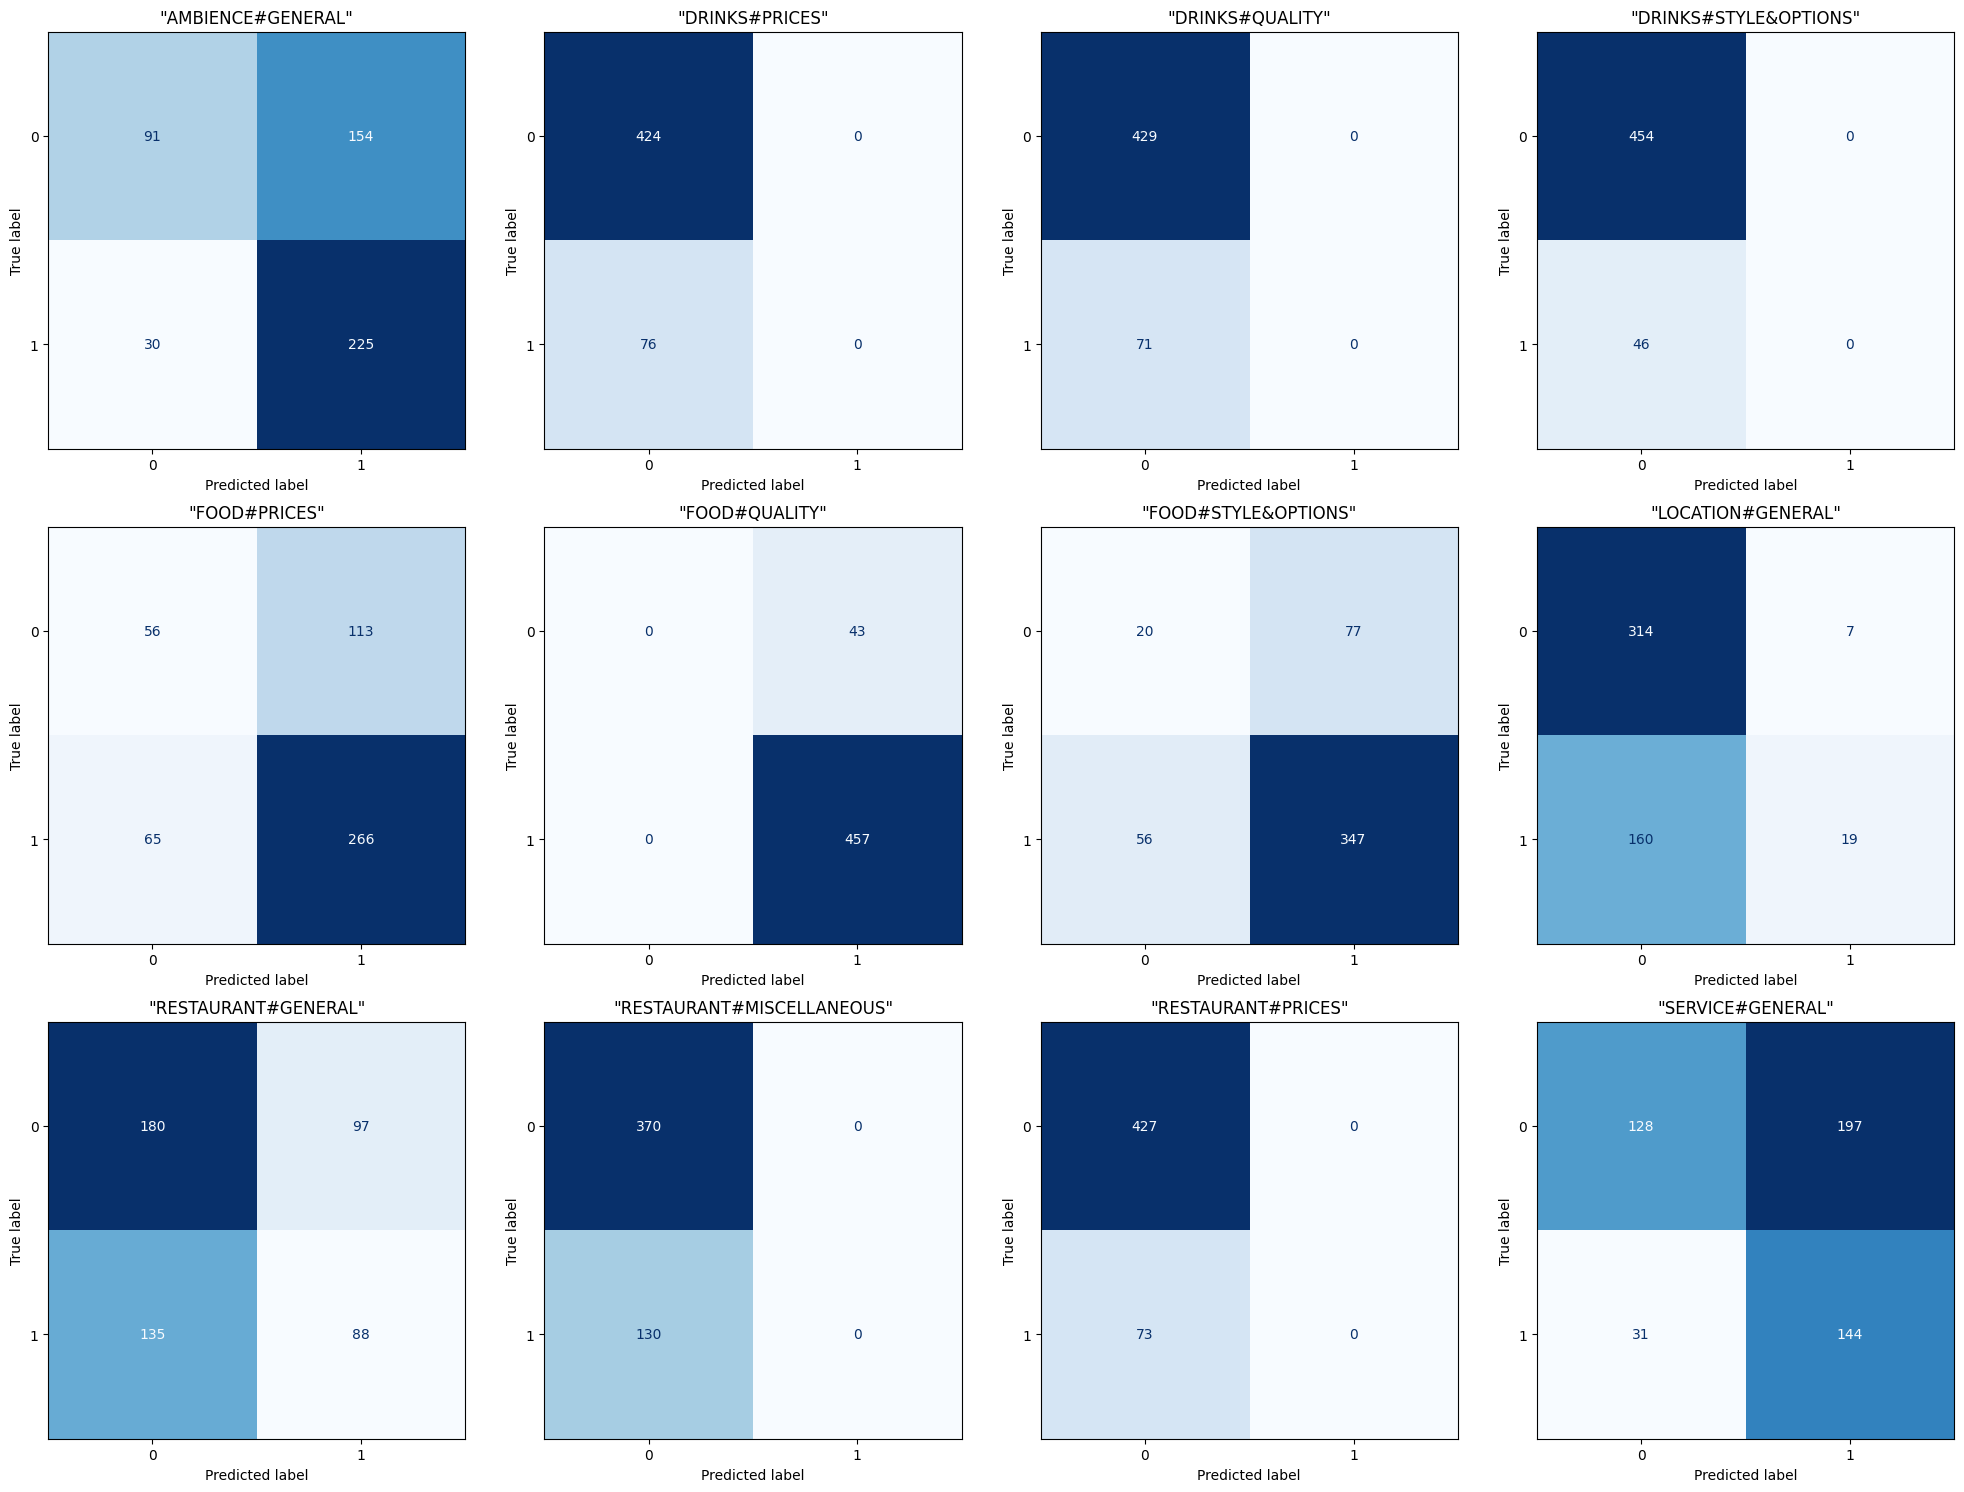

In [8]:
# Confusion Matrix Visualization for Aspect Detection
cols = 4
total = len(aspect_columns)
rows = (total + cols - 1) // cols 

fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 5 * rows))
if rows == 1:
    axes = axes.reshape(1, -1)
axes = axes.flatten() 

for i, aspect in enumerate(aspect_columns):
    if aspect + "_label" in y_test_aspect.columns:
        y_true = y_test_aspect[aspect + "_label"]
        y_pred = y_pred_aspect_binary[:, i]

        cm = confusion_matrix(y_true, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
        disp.plot(ax=axes[i], cmap='Blues', colorbar=False)
        axes[i].set_title(f'"{aspect}"')

# Remove unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [9]:
# SENTIMENT CLASSIFICATION
# Restaurant sentiment mapping: 0=none(-1), 1=positive(2), 2=neutral(1), 3=negative(0)
sentiment_map = {0: -1, 1: 2, 2: 1, 3: 0}  # Map to: none, positive, neutral, negative

y_train_sentiment = {}
y_test_sentiment = {}

for aspect in aspect_columns:
    y_train_sentiment[aspect] = train_df[aspect].map(sentiment_map).fillna(-1).astype(int)
    y_test_sentiment[aspect] = test_df[aspect].map(sentiment_map).fillna(-1).astype(int)

# Check sentiment distribution
print("Sentiment distribution in training set:")
for aspect in aspect_columns[:5]:  # Show first 5 aspects
    print(f"\n{aspect}:")
    sentiment_counts = y_train_sentiment[aspect].value_counts().sort_index()
    for sent, count in sentiment_counts.items():
        label = {-1: 'none', 0: 'negative', 1: 'neutral', 2: 'positive'}[sent]
        print(f"  {label}: {count} ({count/len(y_train_sentiment[aspect])*100:.1f}%)")

Sentiment distribution in training set:

AMBIENCE#GENERAL:
  none: 2224 (75.1%)
  negative: 132 (4.5%)
  neutral: 92 (3.1%)
  positive: 513 (17.3%)

DRINKS#PRICES:
  none: 2859 (96.6%)
  negative: 32 (1.1%)
  neutral: 13 (0.4%)
  positive: 57 (1.9%)

DRINKS#QUALITY:
  none: 2847 (96.1%)
  negative: 10 (0.3%)
  neutral: 12 (0.4%)
  positive: 92 (3.1%)

DRINKS#STYLE&OPTIONS:
  none: 2859 (96.6%)
  negative: 2 (0.1%)
  neutral: 4 (0.1%)
  positive: 96 (3.2%)

FOOD#PRICES:
  none: 1560 (52.7%)
  negative: 566 (19.1%)
  neutral: 133 (4.5%)
  positive: 702 (23.7%)


In [ ]:
# Train individual BiLSTM models for sentiment classification per aspect
pipeline_sentiment = {}

print("Training sentiment models for each aspect...")
for aspect in aspect_columns:
    mask_train = train_df[aspect + "_label"] == 1
    X_train_aspect = train_df[mask_train]
    y_train_aspect_sentiment = y_train_sentiment[aspect][mask_train]
    
    if len(X_train_aspect) > 10:  
        print(f"\nTraining sentiment model for {aspect} ({len(X_train_aspect)} samples)")
        
        sentiment_BiLSTM = Sequential([
            vectorizer,
            Embedding(input_dim=vocab_size, output_dim=100),
            Bidirectional(LSTM(64)),
            Dense(3, activation='softmax') 
        ])
        
        sentiment_BiLSTM.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        sentiment_BiLSTM.fit(X_train_aspect['Review'].astype(str).values, y_train_aspect_sentiment.values, 
                            epochs=3, verbose=0)
        
        pipeline_sentiment[aspect] = sentiment_BiLSTM
    else:
        print(f"Skipping {aspect} (insufficient samples: {len(X_train_aspect)})")
        pipeline_sentiment[aspect] = None

print(f"\nTrained sentiment models for {sum(1 for v in pipeline_sentiment.values() if v is not None)} aspects")

Training sentiment models for each aspect...

Training sentiment model for AMBIENCE#GENERAL (737 samples)

Training sentiment model for DRINKS#PRICES (102 samples)

Training sentiment model for DRINKS#PRICES (102 samples)

Training sentiment model for DRINKS#QUALITY (114 samples)

Training sentiment model for DRINKS#QUALITY (114 samples)

Training sentiment model for DRINKS#STYLE&OPTIONS (102 samples)

Training sentiment model for DRINKS#STYLE&OPTIONS (102 samples)

Training sentiment model for FOOD#PRICES (1401 samples)

Training sentiment model for FOOD#PRICES (1401 samples)

Training sentiment model for FOOD#QUALITY (2658 samples)

Training sentiment model for FOOD#QUALITY (2658 samples)

Training sentiment model for FOOD#STYLE&OPTIONS (1746 samples)

Training sentiment model for FOOD#STYLE&OPTIONS (1746 samples)

Training sentiment model for LOCATION#GENERAL (373 samples)

Training sentiment model for LOCATION#GENERAL (373 samples)

Training sentiment model for RESTAURANT#GENERAL (

In [ ]:
# Make sentiment predictions
num_samples = len(X_test)
y_pred_sentiment = np.full((num_samples, len(aspect_columns)), -1)

print("Making sentiment predictions...")
for i, aspect in enumerate(aspect_columns):
    model = pipeline_sentiment[aspect]
    if model is not None:
        mask_pred = y_pred_aspect_binary[:, i] == 1 
        if np.any(mask_pred):
            X_test_aspect = X_test[mask_pred].astype(str).values
            
            y_pred_prob = model.predict(X_test_aspect, verbose=0)
            y_pred_label = np.argmax(y_pred_prob, axis=1)
            
            y_pred_sentiment[mask_pred, i] = y_pred_label

f1_sc_list = []
print("\nSentiment Classification F1 Scores:")
for i, aspect in enumerate(aspect_columns):
    mask = (y_pred_aspect_binary[:, i] == 1) & (y_test_sentiment[aspect] != -1)
    if np.sum(mask) > 5: 
        f1 = f1_score(
            y_test_sentiment[aspect][mask],
            y_pred_sentiment[mask, i],
            average='weighted'
        )
        f1_sc_list.append(f1)
        print(f"F1_sc ({aspect}): {f1:.4f} ({np.sum(mask)} samples)")

if f1_sc_list:
    print(f"\nOverall F1_sc (weighted average): {np.mean(f1_sc_list):.4f}")
else:
    print("\nNo sentiment predictions could be evaluated")

Making sentiment predictions...

Sentiment Classification F1 Scores:
F1_sc (AMBIENCE#GENERAL): 0.6139 (225 samples)
F1_sc (FOOD#PRICES): 0.5133 (266 samples)
F1_sc (FOOD#QUALITY): 0.8291 (457 samples)
F1_sc (FOOD#STYLE&OPTIONS): 0.7358 (347 samples)
F1_sc (LOCATION#GENERAL): 0.4019 (19 samples)
F1_sc (RESTAURANT#GENERAL): 0.8823 (88 samples)
F1_sc (SERVICE#GENERAL): 0.6301 (144 samples)

Overall F1_sc (weighted average): 0.6581

Sentiment Classification F1 Scores:
F1_sc (AMBIENCE#GENERAL): 0.6139 (225 samples)
F1_sc (FOOD#PRICES): 0.5133 (266 samples)
F1_sc (FOOD#QUALITY): 0.8291 (457 samples)
F1_sc (FOOD#STYLE&OPTIONS): 0.7358 (347 samples)
F1_sc (LOCATION#GENERAL): 0.4019 (19 samples)
F1_sc (RESTAURANT#GENERAL): 0.8823 (88 samples)
F1_sc (SERVICE#GENERAL): 0.6301 (144 samples)

Overall F1_sc (weighted average): 0.6581


# **BiGRU**

In [12]:
from tensorflow.keras.layers import GRU

X_train_BiGRU = vectorizer(X_train.astype(str))
X_test_BiGRU = vectorizer(X_test.astype(str))

BiGRU = Sequential([
    Embedding(input_dim=vocab_size, output_dim=100),
    Bidirectional(GRU(64)),
    Dense(len(aspect_labels), activation='sigmoid')
])

BiGRU.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
BiGRU.fit(X_train_BiGRU, y_train_aspect, epochs=5, batch_size=32, validation_split=0.2)

y_pred_aspect_gru = BiGRU.predict(X_test_BiGRU)
y_pred_aspect_gru_binary = (y_pred_aspect_gru >= 0.5).astype(int)

f1_ad_gru = f1_score(y_test_aspect, y_pred_aspect_gru_binary, average='micro')
print(f"BiGRU F1_ad: {f1_ad_gru:.4f}")

Epoch 1/5
74/74 ━━━━━━━━━━━━━━━━━━━━ 13s 151ms/step - accuracy: 0.3199 - loss: 0.5155 - val_accuracy: 0.3255 - val_loss: 0.4014
Epoch 2/5
74/74 ━━━━━━━━━━━━━━━━━━━━ 13s 151ms/step - accuracy: 0.3199 - loss: 0.5155 - val_accuracy: 0.3255 - val_loss: 0.4014
Epoch 2/5
74/74 ━━━━━━━━━━━━━━━━━━━━ 11s 153ms/step - accuracy: 0.3652 - loss: 0.3562 - val_accuracy: 0.3255 - val_loss: 0.3893
Epoch 3/5
74/74 ━━━━━━━━━━━━━━━━━━━━ 11s 153ms/step - accuracy: 0.3652 - loss: 0.3562 - val_accuracy: 0.3255 - val_loss: 0.3893
Epoch 3/5
74/74 ━━━━━━━━━━━━━━━━━━━━ 11s 144ms/step - accuracy: 0.3727 - loss: 0.3271 - val_accuracy: 0.3592 - val_loss: 0.3721
Epoch 4/5
74/74 ━━━━━━━━━━━━━━━━━━━━ 11s 144ms/step - accuracy: 0.3727 - loss: 0.3271 - val_accuracy: 0.3592 - val_loss: 0.3721
Epoch 4/5
74/74 ━━━━━━━━━━━━━━━━━━━━ 11s 145ms/step - accuracy: 0.3583 - loss: 0.3069 - val_accuracy: 0.3693 - val_loss: 0.3741
Epoch 5/5
74/74 ━━━━━━━━━━━━━━━━━━━━ 11s 145ms/step - accuracy: 0.3583 - loss: 0.3069 - val_accuracy: 0.

In [13]:
# BiGRU Sentiment Classification
pipeline_sentiment_gru = {}

for aspect in aspect_columns:
    mask_train = train_df[aspect + "_label"] == 1
    X_train_aspect = train_df[mask_train]
    y_train_aspect_sentiment = y_train_sentiment[aspect][mask_train]
    
    if len(X_train_aspect) > 10:
        sentiment_BiGRU = Sequential([
            vectorizer,
            Embedding(input_dim=vocab_size, output_dim=100),
            Bidirectional(GRU(64)),
            Dense(3, activation='softmax')
        ])
        
        sentiment_BiGRU.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        sentiment_BiGRU.fit(X_train_aspect['Review'].astype(str).values, y_train_aspect_sentiment.values, 
                           epochs=3, verbose=0)
        
        pipeline_sentiment_gru[aspect] = sentiment_BiGRU
    else:
        pipeline_sentiment_gru[aspect] = None

# BiGRU Sentiment Predictions
num_samples = len(X_test)
y_pred_sentiment_gru = np.full((num_samples, len(aspect_columns)), -1)

for i, aspect in enumerate(aspect_columns):
    model = pipeline_sentiment_gru[aspect]
    if model is not None:
        mask_pred = y_pred_aspect_gru_binary[:, i] == 1
        if np.any(mask_pred):
            X_test_aspect = X_test[mask_pred].astype(str).values
            y_pred_prob = model.predict(X_test_aspect, verbose=0)
            y_pred_label = np.argmax(y_pred_prob, axis=1)
            y_pred_sentiment_gru[mask_pred, i] = y_pred_label

f1_sc_list_gru = []
for i, aspect in enumerate(aspect_columns):
    mask = (y_pred_aspect_gru_binary[:, i] == 1) & (y_test_sentiment[aspect] != -1)
    if np.sum(mask) > 5:
        f1 = f1_score(y_test_sentiment[aspect][mask], y_pred_sentiment_gru[mask, i], average='weighted')
        f1_sc_list_gru.append(f1)

f1_sc_gru = np.mean(f1_sc_list_gru) if f1_sc_list_gru else 0
print(f"BiGRU F1_sc: {f1_sc_gru:.4f}")

BiGRU F1_sc: 0.6376


# **BiLSTM + Conv1D**

In [14]:
BiLSTM_Conv1D = Sequential([
    Embedding(input_dim=vocab_size, output_dim=100),
    Bidirectional(LSTM(64, return_sequences=True)),
    Conv1D(filters=128, kernel_size=3, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(len(aspect_labels), activation='sigmoid')
])

BiLSTM_Conv1D.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
BiLSTM_Conv1D.fit(X_train_BiLSTM, y_train_aspect, epochs=5, batch_size=32, validation_split=0.2)

y_pred_aspect_conv = BiLSTM_Conv1D.predict(X_test_BiLSTM)
y_pred_aspect_conv_binary = (y_pred_aspect_conv >= 0.5).astype(int)

f1_ad_conv = f1_score(y_test_aspect, y_pred_aspect_conv_binary, average='micro')
print(f"BiLSTM+Conv1D F1_ad: {f1_ad_conv:.4f}")

Epoch 1/5
74/74 ━━━━━━━━━━━━━━━━━━━━ 14s 161ms/step - accuracy: 0.3483 - loss: 0.4745 - val_accuracy: 0.2597 - val_loss: 0.4159
Epoch 2/5
74/74 ━━━━━━━━━━━━━━━━━━━━ 14s 161ms/step - accuracy: 0.3483 - loss: 0.4745 - val_accuracy: 0.2597 - val_loss: 0.4159
Epoch 2/5
74/74 ━━━━━━━━━━━━━━━━━━━━ 12s 168ms/step - accuracy: 0.3555 - loss: 0.3577 - val_accuracy: 0.3255 - val_loss: 0.3683
Epoch 3/5
74/74 ━━━━━━━━━━━━━━━━━━━━ 12s 168ms/step - accuracy: 0.3555 - loss: 0.3577 - val_accuracy: 0.3255 - val_loss: 0.3683
Epoch 3/5
74/74 ━━━━━━━━━━━━━━━━━━━━ 12s 167ms/step - accuracy: 0.3442 - loss: 0.3164 - val_accuracy: 0.3255 - val_loss: 0.3502
Epoch 4/5
74/74 ━━━━━━━━━━━━━━━━━━━━ 12s 167ms/step - accuracy: 0.3442 - loss: 0.3164 - val_accuracy: 0.3255 - val_loss: 0.3502
Epoch 4/5
74/74 ━━━━━━━━━━━━━━━━━━━━ 13s 170ms/step - accuracy: 0.3490 - loss: 0.2782 - val_accuracy: 0.3457 - val_loss: 0.3427
Epoch 5/5
74/74 ━━━━━━━━━━━━━━━━━━━━ 13s 170ms/step - accuracy: 0.3490 - loss: 0.2782 - val_accuracy: 0.

In [15]:
# BiLSTM+Conv1D Sentiment Classification
pipeline_sentiment_conv = {}

for aspect in aspect_columns:
    mask_train = train_df[aspect + "_label"] == 1
    X_train_aspect = train_df[mask_train]
    y_train_aspect_sentiment = y_train_sentiment[aspect][mask_train]
    
    if len(X_train_aspect) > 10:
        sentiment_Conv = Sequential([
            vectorizer,
            Embedding(input_dim=vocab_size, output_dim=100),
            Bidirectional(LSTM(64, return_sequences=True)),
            Conv1D(filters=128, kernel_size=3, activation='relu'),
            GlobalMaxPooling1D(),
            Dense(3, activation='softmax')
        ])
        
        sentiment_Conv.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        sentiment_Conv.fit(X_train_aspect['Review'].astype(str).values, y_train_aspect_sentiment.values, 
                          epochs=3, verbose=0)
        
        pipeline_sentiment_conv[aspect] = sentiment_Conv
    else:
        pipeline_sentiment_conv[aspect] = None

# BiLSTM+Conv1D Sentiment Predictions
y_pred_sentiment_conv = np.full((num_samples, len(aspect_columns)), -1)

for i, aspect in enumerate(aspect_columns):
    model = pipeline_sentiment_conv[aspect]
    if model is not None:
        mask_pred = y_pred_aspect_conv_binary[:, i] == 1
        if np.any(mask_pred):
            X_test_aspect = X_test[mask_pred].astype(str).values
            y_pred_prob = model.predict(X_test_aspect, verbose=0)
            y_pred_label = np.argmax(y_pred_prob, axis=1)
            y_pred_sentiment_conv[mask_pred, i] = y_pred_label

f1_sc_list_conv = []
for i, aspect in enumerate(aspect_columns):
    mask = (y_pred_aspect_conv_binary[:, i] == 1) & (y_test_sentiment[aspect] != -1)
    if np.sum(mask) > 5:
        f1 = f1_score(y_test_sentiment[aspect][mask], y_pred_sentiment_conv[mask, i], average='weighted')
        f1_sc_list_conv.append(f1)

f1_sc_conv = np.mean(f1_sc_list_conv) if f1_sc_list_conv else 0
print(f"BiLSTM+Conv1D F1_sc: {f1_sc_conv:.4f}")

BiLSTM+Conv1D F1_sc: 0.6791


In [16]:
print("=== Restaurant Dataset - Model Comparison ===")
print(f"BiLSTM F1_ad: {f1_ad:.4f}, F1_sc: {np.mean(f1_sc_list):.4f}")
print(f"BiGRU F1_ad: {f1_ad_gru:.4f}, F1_sc: {f1_sc_gru:.4f}")
print(f"BiLSTM+Conv1D F1_ad: {f1_ad_conv:.4f}, F1_sc: {f1_sc_conv:.4f}")

=== Restaurant Dataset - Model Comparison ===
BiLSTM F1_ad: 0.6645, F1_sc: 0.6581
BiGRU F1_ad: 0.6343, F1_sc: 0.6376
BiLSTM+Conv1D F1_ad: 0.7043, F1_sc: 0.6791
